In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import requests
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from autowoe import AutoWoE, ReportDeco

In [ ]:
train = pd.read_csv('catboost_train.csv')
oos = pd.read_csv('catboost_oos.csv')
oot = pd.read_csv('catboost_oot.csv')

In [ ]:
cols= ['all_util', 'annual_inc', 'bc_open_to_buy', 'dti', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'installment', 'last_fico_range_high', 'last_fico_range_low', 'loan_amnt', 'mo_sin_old_rev_tl_op', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'open_il_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'revol_util', 'term', 'tot_cur_bal', 'total_acc', 'loan_condition_int']

In [ ]:
train = train[cols]
oos = oos[cols]
oot = oot[cols]

In [ ]:
#!pip install scorecardpy
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression

# woe binning ------
bins = sc.woebin(train, y='loan_condition_int')


# converting train and test into woe values
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(oos, bins)
oot_woe = sc.woebin_ply(oot, bins)

y_train = train_woe.loc[:,'loan_condition_int']
X_train = train_woe.loc[:,train_woe.columns != 'loan_condition_int']
y_test = test_woe.loc[:,'loan_condition_int']
X_test = test_woe.loc[:,train_woe.columns != 'loan_condition_int']
y_OOT = oot_woe.loc[:,'loan_condition_int']
X_OOT = oot_woe.loc[:,train_woe.columns != 'loan_condition_int']

[INFO] creating woe binning ...
Binning on 1298859 rows and 25 columns in 00:01:57
[INFO] converting into woe values ...
Woe transformating on 1298859 rows and 24 columns in 00:01:08
[INFO] converting into woe values ...
Woe transformating on 432954 rows and 24 columns in 00:00:24
[INFO] converting into woe values ...
Woe transformating on 298139 rows and 24 columns in 00:00:17


In [ ]:
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train, y_train)

LogisticRegression(C=0.9, n_jobs=-1, penalty='l1', solver='saga')

In [ ]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]
oot_pred = lr.predict_proba(X_OOT)[:,1]

In [ ]:
roc_auc = roc_auc_score(y_test, test_pred)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))
print('Gini score: {}'.format(gini))

ROC-AUC score: 0.9389013515250422
Gini score: 0.8778027030500843


In [ ]:
roc_auc = roc_auc_score(y_OOT, oot_pred)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))
print('Gini score: {}'.format(gini))

ROC-AUC score: 0.8448783044592952
Gini score: 0.6897566089185905


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95    367990
           1       0.74      0.69      0.71     64964

    accuracy                           0.92    432954
   macro avg       0.84      0.82      0.83    432954
weighted avg       0.91      0.92      0.92    432954



In [ ]:
print(classification_report(y_OOT, lr.predict(X_OOT)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99    290484
           1       0.60      0.34      0.44      7655

    accuracy                           0.98    298139
   macro avg       0.79      0.67      0.71    298139
weighted avg       0.97      0.98      0.97    298139



<AxesSubplot: ylabel='Feature'>

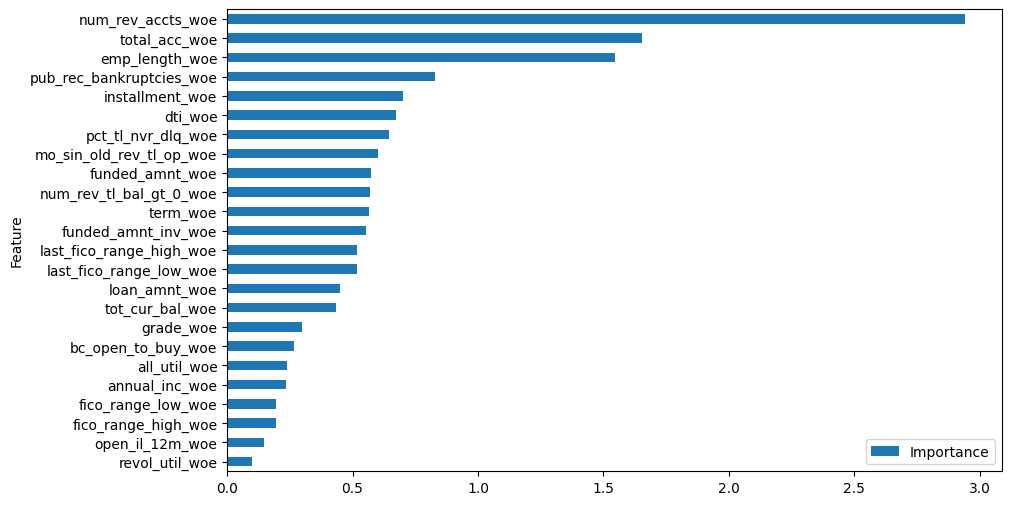

In [ ]:
coefficients = lr.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
train = pd.read_csv('catboost_train.csv')
oos = pd.read_csv('catboost_oos.csv')
oot = pd.read_csv('catboost_oot.csv')
train_csv = X_train.copy()

train_csv['funded_amnt'] = train['funded_amnt']
train_csv['issue_d'] = train['issue_d']
train_csv.to_csv('train_for_7')
test_csv = X_test.copy()

test_csv['funded_amnt'] = oos['funded_amnt']
test_csv['issue_d'] = oos['issue_d']
test_csv.to_csv('test_for_7')
OOT_csv = X_OOT.copy()

OOT_csv['funded_amnt'] = oot['funded_amnt']
OOT_csv['issue_d'] = oot['issue_d']
OOT_csv.to_csv('oot_for_7')
pd.read_csv('train').shape, pd.read_csv('OOS').shape, pd.read_csv('OOT').shape
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
X_OOT.to_csv('X_oot.csv')

### Предикты

### Метрики качества

### Оптимизируем трешхолд для повышения f1-score

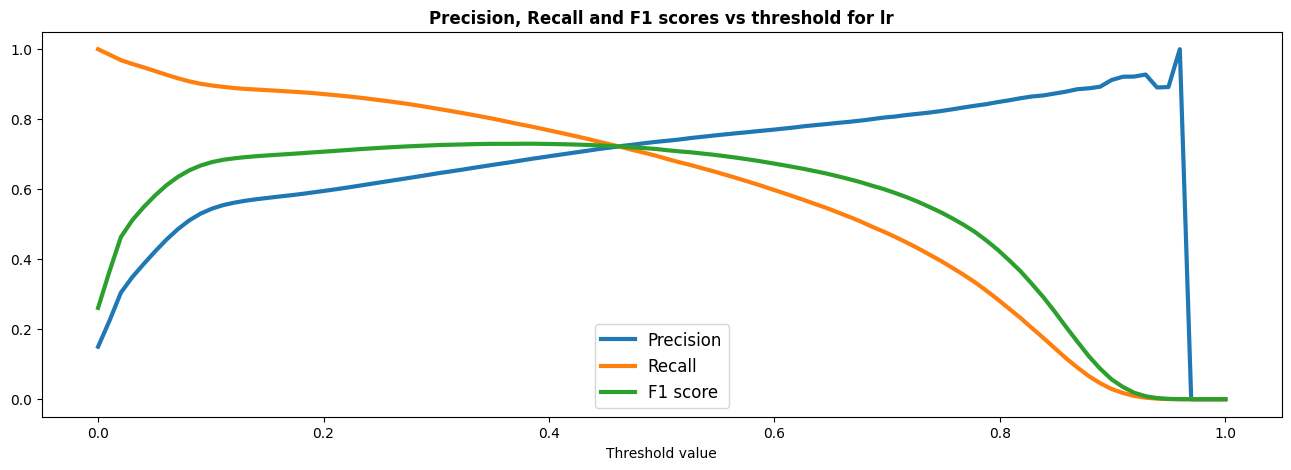

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
scores = lr.predict_proba(X_test)[:,1]


tr = np.linspace(0, 1, 100)

p = np.zeros_like(tr)
r = np.zeros_like(tr)
f = np.zeros_like(tr)

for k, x in enumerate(tr):

    y_pred = scores >= x

    p[k] = precision_score(y_test, y_pred)
    r[k] = recall_score(y_test, y_pred)
    f[k] = f1_score(y_test, y_pred)


fig = plt.figure(figsize=(16, 5))

plt.plot(tr, p, linewidth=3)
plt.plot(tr, r, linewidth=3)
plt.plot(tr, f, linewidth=3)

plt.title("Precision, Recall and F1 scores vs threshold for lr", weight="bold")

plt.xlabel("Threshold value")

plt.legend(['Precision', 'Recall', 'F1 score'], fontsize=12)

plt.show()

In [ ]:
y_pred_new_threshold = (lr.predict_proba(X_test)[:,1]>=0.45).astype(int)
roc_auc = roc_auc_score(y_test, y_pred_new_threshold)
gini = (2 * roc_auc) - 1
print('ROC-AUC score: {}' .format(roc_auc))
print('Gini score: {}'.format(gini))
print('F1-score: {}'.format(f1_score(y_test, y_pred_new_threshold)))

ROC-AUC score: 0.8402272275721988
Gini score: 0.6804544551443976
F1-score: 0.7242654064560387
